# 02 – Sentiment Signals vs. Post-Call Returns

This notebook links the earnings-call sentiment features to market data, builds forward returns, and evaluates whether the sentiment signal helps explain post-call stock performance.

## Roadmap
1. Load sentiment aggregates and attach event dates (`ec_mapping`).
2. Stream the relevant prices from `algoseek_nyse_nasdaq.parquet` and compute forward returns.
3. maybe add quarterly fundamentals (`additional_ec_data`).
4. Build descriptive views (coverage, sentiment trends, return distributions).
5. Run a simple regression of returns on sentiment features and export artefacts for the presentation.

In [2]:
from __future__ import annotations

import json
import logging
from pathlib import Path
from typing import Iterable, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pyarrow as pa
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-v0_8')
pd.options.display.max_columns = 40
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


In [ ]:
# --- Configuration ------------------------------------------------------
DATA_DIR = Path('data')
OUTPUT_DIR = Path('output')
FIG_DIR = OUTPUT_DIR / 'fig_dark'
OUTPUT_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(exist_ok=True)

FINBERT_SENTIMENT_FEATURES_PATH = OUTPUT_DIR / 'finbert_sentiment_features.parquet'
EC_MAPPING_PATH = DATA_DIR / 'ec_mapping.parquet'
PRICES_PATH = DATA_DIR / 'algoseek_nyse_nasdaq.parquet'
ADDITIONAL_DATA_PATH = DATA_DIR / 'additional_ec_data.parquet'
VAR_DESCRIPTIONS_PATH = DATA_DIR / 'var_descriptions.parquet'

RETURN_WINDOWS = [1, 3, 5]
MERGE_TOLERANCE_DAYS = 5
PRICE_COLUMNS = ['Date', 'Ticker', 'CloseAdjusted']
PRICE_CHUNK_SIZE = 60
RANDOM_STATE = 42

FUNDAMENTAL_COLUMNS = [
    'tic', 'rdq_x', 'sic', 'naics',
    'saleq', 'niq', 'epspxq', 'atq', 'seqq', 'ceqq'
]


In [4]:
matplotlib_dark_theme = True

if matplotlib_dark_theme:
	plt.rcParams.update({
		# Fonts and text
		"text.color": "white",
		"axes.labelcolor": "white",
		"xtick.color": "white",
		"ytick.color": "white",

		# Axes/spines
		"axes.edgecolor": "white",  # borders
		"xtick.color": "white",
		"ytick.color": "white",
		"grid.color": "white",

		# Background
		"figure.facecolor": "none",  # transparent
		"axes.facecolor": "none"
	})

In [5]:
# --- Helper utilities ----------------------------------------------------
def chunked(seq: Iterable[str], size: int) -> Iterable[List[str]]:
    seq = list(seq)
    for idx in range(0, len(seq), size):
        yield seq[idx: idx + size]


def load_price_panel(
    price_path: Path,
    tickers: Iterable[str],
    start_date: pd.Timestamp,
    end_date: pd.Timestamp,
    columns: List[str],
    chunk_size: int = 60,
) -> pd.DataFrame:
    dataset = ds.dataset(price_path, format='parquet')
    results: List[pd.DataFrame] = []
    # ensure these are dates, not pandas Timestamps with time
    start = pa.scalar(pd.Timestamp(start_date).date(), type=pa.date32())
    end  = pa.scalar(pd.Timestamp(end_date).date(),   type=pa.date32())
    
    date_col = ds.field("Date").cast(pa.date32())

    for batch in chunked(sorted(set(tickers)), max(chunk_size, 1)):
        
        
        filter_expr = (
            (ds.field('Ticker').isin(batch))
            & (date_col>= start)
            & (date_col <= end)
        )
        table = dataset.to_table(columns=columns, filter=filter_expr)
        if table.num_rows:
            results.append(table.to_pandas())
    if not results:
        logging.warning('No price data retrieved — check ticker symbols and date window.')
        return pd.DataFrame(columns=columns)
    prices = pd.concat(results, ignore_index=True)
    prices['Date'] = pd.to_datetime(prices['Date'])
    prices['Ticker'] = prices['Ticker'].astype(str)
    prices = prices.sort_values(['Date', 'Ticker']).reset_index(drop=True)
    return prices


def attach_forward_returns(price_df: pd.DataFrame, windows: List[int]) -> pd.DataFrame:
    price_df = price_df.copy()
    price_df = price_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
    for window in windows:
        price_df[f'CloseAdjusted_plus_{window}'] = (
            price_df.groupby('Ticker')['CloseAdjusted'].shift(-window)
        )
    return price_df


def merge_event_returns(
    events: pd.DataFrame,
    price_panel: pd.DataFrame,
    windows: List[int],
    tolerance_days: int = 5,
) -> pd.DataFrame:
    if price_panel.empty:
        raise ValueError('Price panel is empty. Check the loading step.')
    price_panel = price_panel.copy()
    price_panel['Ticker'] = price_panel['Ticker'].astype(str)
    price_panel = price_panel.sort_values(['Date', 'Ticker'], kind='mergesort').reset_index(drop=True)

    events = events.copy()
    events = events[events['symbol'].notna() & events['rdq'].notna()]
    events['symbol'] = events['symbol'].astype(str)
    events['rdq'] = pd.to_datetime(events['rdq'])
    events = events.sort_values(['rdq', 'symbol'], kind='mergesort').reset_index(drop=True)

    base_cols = ['Ticker', 'Date', 'CloseAdjusted'] + [
        f'CloseAdjusted_plus_{w}' for w in windows
    ]
    prices_base = price_panel[base_cols].sort_values(['Date', 'Ticker'], kind='mergesort').reset_index(drop=True)

    left = events.rename(columns={'symbol': 'Ticker'})
    left = left.sort_values(['rdq', 'Ticker'], kind='mergesort').reset_index(drop=True)

    merged = pd.merge_asof(
        left,
        prices_base,
        left_on='rdq',
        right_on='Date',
        by='Ticker',
        direction='forward',
        tolerance=pd.Timedelta(days=tolerance_days),
    )

    merged = merged.rename(
        columns={
            'Ticker': 'symbol',
            'Date': 'price_anchor_date',
            'CloseAdjusted': 'anchor_close',
        }
    )
    merged['price_matched'] = merged['anchor_close'].notna()

    for window in windows:
        future_col = f'CloseAdjusted_plus_{window}'
        merged[future_col] = merged[future_col].astype(float)
        merged[f'return_{window}d'] = np.where(
            (merged['price_matched']) & (merged['anchor_close'] > 0),
            merged[future_col] / merged['anchor_close'] - 1,
            np.nan,
        )
        merged = merged.drop(columns=[future_col])

    return merged


def save_figure(fig: plt.Figure, name: str) -> None:
    path = FIG_DIR / f'{name}.png'
    fig.savefig(path, dpi=160, bbox_inches='tight')
    logging.info('Saved figure to %s', path)


def sentiment_feature_columns(df: pd.DataFrame) -> List[str]:
    base = [col for col in df.columns if col.startswith('p_') and col.endswith('_wmean')]
    extras = [col for col in ['entropy_wmean', 'max_positive', 'max_negative'] if col in df.columns]
    return base + extras


In [6]:
# --- Load sentiment features and event mapping -------------------------
sentiment_table = pq.read_table(FINBERT_SENTIMENT_FEATURES_PATH)
sentiment_df = sentiment_table.to_pandas()
logging.info('Loaded sentiment table: %s rows, %s columns', len(sentiment_df), len(sentiment_df.columns))

mapping_df = pq.read_table(EC_MAPPING_PATH).to_pandas()
mapping_df['rdq'] = pd.to_datetime(mapping_df['rdq'])
events_df = sentiment_df.merge(mapping_df, on=['symbol', 'year', 'quarter'], how='inner')
events_df = events_df.sort_values(['symbol', 'rdq']).reset_index(drop=True)
events_df['event_year'] = events_df['rdq'].dt.year
events_df['event_quarter'] = events_df['rdq'].dt.quarter
logging.info('Events with dates: %s rows, %s unique symbols', len(events_df), events_df['symbol'].nunique())
events_df.head()


INFO: Loaded sentiment table: 77304 rows, 24 columns
INFO: Events with dates: 75999 rows, 1676 unique symbols


,symbol,year,quarter,p_positive_wmean,p_positive_std,p_positive_q95,p_positive_q05,share_positive_gt70,p_negative_wmean,p_negative_std,p_negative_q95,p_negative_q05,share_negative_gt70,p_neutral_wmean,p_neutral_std,p_neutral_q95,p_neutral_q05,share_neutral_gt70,entropy_wmean,n_chunks,n_tokens_total,max_positive,max_negative,n_sentences,rdq,event_year,event_quarter
0,A,2010,1,0.469938,0.311108,0.931317,0.107376,0.360000,0.145280,0.217575,0.647554,0.011984,0.040000,0.384782,0.329131,0.848629,0.025148,0.280000,0.612725,25,10374,0.956435,0.867143,324,2010-02-12,2010,1
1,A,2010,2,0.565958,0.337969,0.958179,0.097367,0.454545,0.050713,0.091793,0.109680,0.012531,0.000000,0.383329,0.324060,0.885707,0.020418,0.272727,0.537771,22,9341,0.959201,0.454529,388,2010-05-17,2010,2
2,A,2011,1,0.357049,0.260738,0.943069,0.080761,0.142857,0.142774,0.226975,0.682926,0.014325,0.071429,0.500177,0.279511,0.869540,0.040421,0.250000,0.678462,28,11865,0.953654,0.850958,504,2011-02-14,2011,1
3,A,2011,2,0.463796,0.305944,0.953290,0.097362,0.280000,0.024212,0.012789,0.050775,0.010989,0.000000,0.511992,0.304609,0.871286,0.026085,0.320000,0.560847,25,10786,0.959866,0.053804,517,2011-05-13,2011,2
4,A,2011,3,0.483509,0.312496,0.957271,0.081136,0.269231,0.051944,0.076311,0.188005,0.012761,0.000000,0.464547,0.304825,0.872078,0.027633,0.307692,0.593212,26,11086,0.959664,0.367327,524,2011-08-15,2011,3


In [7]:
# Coverage snapshots
coverage_year = events_df.groupby('event_year')['symbol'].agg(['count', 'nunique']).rename(columns={'count': 'call_count', 'nunique': 'unique_symbols'})
coverage_quarter = events_df.groupby(['event_year', 'event_quarter'])['symbol'].count().rename('call_count').reset_index()
coverage_year.head()


,call_count,unique_symbols
event_year,,
2009,48,48
2010,1747,724
2011,2319,725
2012,3640,1088
2013,3712,1093


In [8]:
# --- Load price data ----------------------------------------------------
event_dates = events_df['rdq']
start_date = event_dates.min() - pd.Timedelta(days=2)
end_date = event_dates.max() + pd.Timedelta(days=max(RETURN_WINDOWS) + 5)
tickers = events_df['symbol'].unique()

price_df = load_price_panel(
    PRICES_PATH,
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    columns=PRICE_COLUMNS,
    chunk_size=PRICE_CHUNK_SIZE,
)
logging.info('Price panel shape: %s', price_df.shape)
price_df.head()


INFO: Price panel shape: (4829520, 3)


,Date,Ticker,CloseAdjusted
0,2010-01-04,A,20.3820
1,2010-01-04,AA,25.3612
2,2010-01-04,AAON,3.4964
3,2010-01-04,AAP,36.2825
4,2010-01-04,AAPL,6.4759


In [9]:
# Augment with forward closes
price_augmented = attach_forward_returns(price_df, RETURN_WINDOWS)
price_augmented.head()


,Date,Ticker,CloseAdjusted,CloseAdjusted_plus_1,CloseAdjusted_plus_3,CloseAdjusted_plus_5
0,2010-01-04,A,20.3820,20.1542,20.0500,20.0565
1,2010-01-05,A,20.1542,20.0761,20.0696,19.8287
2,2010-01-06,A,20.0761,20.0500,20.0565,19.9589
3,2010-01-07,A,20.0500,20.0696,19.8287,20.2779
4,2010-01-08,A,20.0696,20.0565,19.9589,19.8157


In [10]:
# --- Merge events with prices and compute forward returns --------------
feature_cols_for_merge = [col for col in events_df.columns if col.startswith('p_') or col.startswith('entropy') or col.startswith('max_') or col == 'n_sentences']
events_subset = events_df[['symbol', 'rdq'] + feature_cols_for_merge]
events_with_returns = merge_event_returns(
    events_subset,
    price_augmented,
    windows=RETURN_WINDOWS,
    tolerance_days=MERGE_TOLERANCE_DAYS,
)
match_rate = events_with_returns['price_matched'].mean() if len(events_with_returns) else 0.0
logging.info('Merged events: %s rows (price match rate %.1f%%)', len(events_with_returns), 100 * match_rate)
events_with_returns.head()


INFO: Merged events: 75999 rows (price match rate 82.6%)


,symbol,rdq,p_positive_wmean,p_positive_std,p_positive_q95,p_positive_q05,p_negative_wmean,p_negative_std,p_negative_q95,p_negative_q05,p_neutral_wmean,p_neutral_std,p_neutral_q95,p_neutral_q05,entropy_wmean,max_positive,max_negative,n_sentences,price_anchor_date,anchor_close,price_matched,return_1d,return_3d,return_5d
0,EAT,2009-10-20,0.324630,0.308793,0.895794,0.054883,0.130092,0.256789,0.829215,0.010197,0.545278,0.339434,0.912065,0.030290,0.535122,0.936609,0.931211,397,NaT,NaN,False,NaN,NaN,NaN
1,PH,2009-10-20,0.314825,0.300383,0.818377,0.018877,0.456831,0.385483,0.959265,0.026888,0.228345,0.231331,0.566727,0.022494,0.609030,0.926395,0.963844,401,NaT,NaN,False,NaN,NaN,NaN
2,STX,2009-10-20,0.355619,0.308481,0.945795,0.085756,0.138106,0.213073,0.450151,0.012873,0.506274,0.330965,0.874399,0.031977,0.606226,0.951107,0.953849,425,NaT,NaN,False,NaN,NaN,NaN
3,TPR,2009-10-20,0.569778,0.293881,0.937771,0.024753,0.178911,0.272400,0.929970,0.011281,0.251311,0.216817,0.654585,0.026211,0.637152,0.955502,0.952711,343,NaT,NaN,False,NaN,NaN,NaN
4,WOLF,2009-10-20,0.363586,0.299881,0.949903,0.102464,0.053602,0.087317,0.207895,0.011868,0.582812,0.304524,0.878326,0.035045,0.580716,0.954897,0.420491,470,NaT,NaN,False,NaN,NaN,NaN


In [11]:
# Keep only events with a valid price anchor
model_df = events_with_returns[events_with_returns['price_matched']].copy()
logging.info('Events with price data: %s', len(model_df))
model_df.head()


INFO: Events with price data: 62794


,symbol,rdq,p_positive_wmean,p_positive_std,p_positive_q95,p_positive_q05,p_negative_wmean,p_negative_std,p_negative_q95,p_negative_q05,p_neutral_wmean,p_neutral_std,p_neutral_q95,p_neutral_q05,entropy_wmean,max_positive,max_negative,n_sentences,price_anchor_date,anchor_close,price_matched,return_1d,return_3d,return_5d
48,FC,2010-01-07,0.467119,0.339929,0.944124,0.052645,0.148369,0.243461,0.775829,0.011376,0.384512,0.324949,0.906946,0.019789,0.575972,0.957391,0.887501,295,2010-01-07,6.3600,True,-0.009434,-0.020440,-0.033035
49,WDFC,2010-01-11,0.398475,0.319937,0.821013,0.012230,0.339375,0.386026,0.968616,0.010823,0.262149,0.305561,0.789020,0.019908,0.535301,0.921840,0.969368,248,2010-01-11,25.0938,True,-0.005555,-0.007408,0.011728
50,COHR,2010-01-19,0.601432,0.297318,0.949261,0.185255,0.057441,0.106016,0.221550,0.011499,0.341128,0.306357,0.798230,0.035740,0.553411,0.951695,0.405486,270,2010-01-19,28.6578,True,-0.007516,-0.053982,-0.099760
51,PH,2010-01-19,0.325908,0.297212,0.931498,0.016580,0.307267,0.349097,0.961699,0.019186,0.366824,0.293255,0.884752,0.019157,0.632639,0.951887,0.969317,455,2010-01-19,47.6820,True,-0.012539,-0.061401,-0.078338
52,WOLF,2010-01-19,0.350802,0.311764,0.919908,0.072187,0.036903,0.027727,0.098890,0.010098,0.612295,0.308277,0.886026,0.043747,0.547144,0.958703,0.123139,488,2010-01-19,2.4200,True,-0.037190,-0.057851,-0.049587


In [12]:
# --- Optional: join fundamentals ---------------------------------------
fundamental_names = pq.read_table(ADDITIONAL_DATA_PATH).column_names
requested = [col for col in FUNDAMENTAL_COLUMNS if col in fundamental_names]
if requested:
    fundamentals = pq.read_table(ADDITIONAL_DATA_PATH, columns=requested).to_pandas()
    rename_map = {'tic': 'symbol', 'rdq_x': 'rdq'}
    fundamentals = fundamentals.rename(columns={k: v for k, v in rename_map.items() if k in fundamentals.columns})
    if 'rdq' in fundamentals.columns:
        fundamentals['rdq'] = pd.to_datetime(fundamentals['rdq'])
    model_df = model_df.merge(fundamentals, on=['symbol', 'rdq'], how='left')
    logging.info('Fundamentals joined (columns now: %s)', len(model_df.columns))
else:
    logging.warning('Requested fundamental columns not found; skipping enrichment.')
model_df.head()


INFO: Fundamentals joined (columns now: 32)


,symbol,rdq,p_positive_wmean,p_positive_std,p_positive_q95,p_positive_q05,p_negative_wmean,p_negative_std,p_negative_q95,p_negative_q05,p_neutral_wmean,p_neutral_std,p_neutral_q95,p_neutral_q05,entropy_wmean,max_positive,max_negative,n_sentences,price_anchor_date,anchor_close,price_matched,return_1d,return_3d,return_5d,sic,naics,saleq,niq,epspxq,atq,seqq,ceqq
0,FC,2010-01-07,0.467119,0.339929,0.944124,0.052645,0.148369,0.243461,0.775829,0.011376,0.384512,0.324949,0.906946,0.019789,0.575972,0.957391,0.887501,295,2010-01-07,6.3600,True,-0.009434,-0.020440,-0.033035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WDFC,2010-01-11,0.398475,0.319937,0.821013,0.012230,0.339375,0.386026,0.968616,0.010823,0.262149,0.305561,0.789020,0.019908,0.535301,0.921840,0.969368,248,2010-01-11,25.0938,True,-0.005555,-0.007408,0.011728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,COHR,2010-01-19,0.601432,0.297318,0.949261,0.185255,0.057441,0.106016,0.221550,0.011499,0.341128,0.306357,0.798230,0.035740,0.553411,0.951695,0.405486,270,2010-01-19,28.6578,True,-0.007516,-0.053982,-0.099760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PH,2010-01-19,0.325908,0.297212,0.931498,0.016580,0.307267,0.349097,0.961699,0.019186,0.366824,0.293255,0.884752,0.019157,0.632639,0.951887,0.969317,455,2010-01-19,47.6820,True,-0.012539,-0.061401,-0.078338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WOLF,2010-01-19,0.350802,0.311764,0.919908,0.072187,0.036903,0.027727,0.098890,0.010098,0.612295,0.308277,0.886026,0.043747,0.547144,0.958703,0.123139,488,2010-01-19,2.4200,True,-0.037190,-0.057851,-0.049587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Persist the modelling dataset for downstream use
model_path = OUTPUT_DIR / 'sentiment_returns.parquet'
model_df.to_parquet(model_path, index=False)
logging.info('Saved modelling dataset to %s', model_path)


INFO: Saved modelling dataset to output/sentiment_returns.parquet


In [14]:
# Figures are saved to output/fig for easy reuse in slides


INFO: Saved figure to output/fig_dark/coverage_by_year.png
INFO: Saved figure to output/fig_dark/price_match_by_year.png


,matched,total,match_rate
2009,0,48,0.000000
2010,1571,1747,0.899256
2011,2086,2319,0.899526
2012,3279,3640,0.900824
2013,3366,3712,0.906789


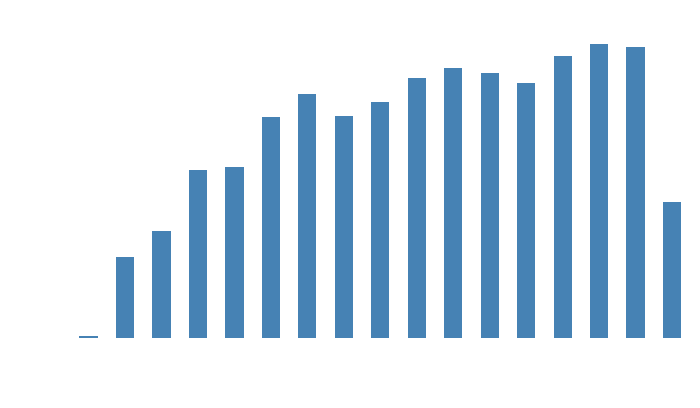

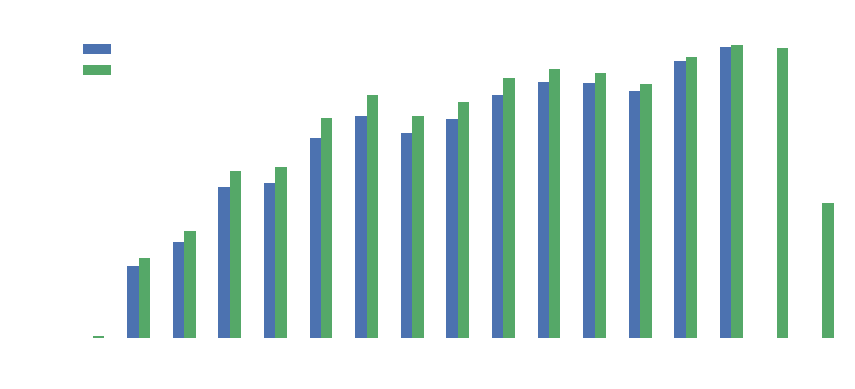

In [15]:
# Coverage: calls per year and price match rates
counts_by_year = events_df.groupby('event_year').size().rename('call_count')
match_counts = pd.DataFrame({
    'matched': model_df.groupby(model_df['rdq'].dt.year).size(),
    'total': counts_by_year
}).fillna(0).astype(int)
match_counts['match_rate'] = match_counts['matched'] / match_counts['total'].replace(0, np.nan)
fig, ax = plt.subplots(figsize=(8, 4))
counts_by_year.plot(kind='bar', ax=ax, color='steelblue')
ax.set_ylabel('Number of earnings calls')
ax.set_title('Coverage by event year')
ax.grid(axis='y', alpha=0.3)
save_figure(fig, 'coverage_by_year')
fig, ax = plt.subplots(figsize=(10, 4))
match_counts[['matched', 'total']].plot(kind='bar', ax=ax)
ax.set_ylabel('Count')
ax.set_title('Price match coverage by year')
ax.legend(['Matched', 'Total'])
ax.grid(axis='y', alpha=0.3)
save_figure(fig, 'price_match_by_year')
match_counts.head()


INFO: Saved figure to output/fig_dark/sentiment_hist.png


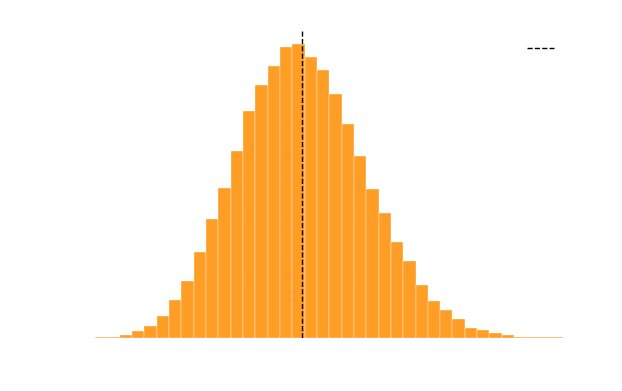

In [16]:
# Sentiment distribution (weighted positive probability)
fig, ax = plt.subplots(figsize=(7, 4))
model_df['p_positive_wmean'].hist(ax=ax, bins=40, color='darkorange', edgecolor='white', alpha=0.85)
ax.set_xlabel('Weighted positive sentiment')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of positive sentiment')
ax.axvline(model_df['p_positive_wmean'].mean(), color='black', linestyle='--', linewidth=1, label='Mean')
ax.legend()
save_figure(fig, 'sentiment_hist')


INFO: Saved figure to output/fig_dark/sentiment_hist_negative.png


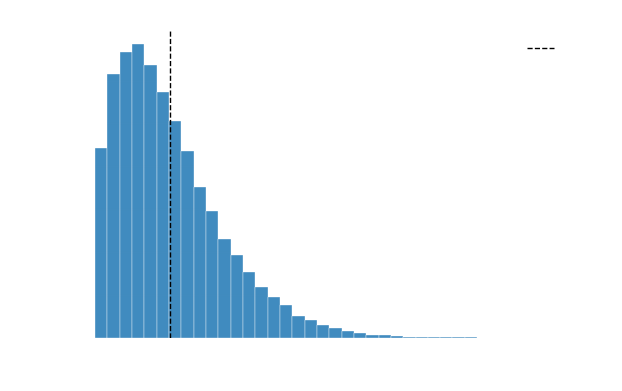

In [17]:
# Sentiment distribution (weighted negative probability)
fig, ax = plt.subplots(figsize=(7, 4))
model_df['p_negative_wmean'].hist(ax=ax, bins=40, color='#1f77b4', edgecolor='white', alpha=0.85)
ax.set_xlabel('Weighted negative sentiment')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of negative sentiment')
ax.axvline(model_df['p_negative_wmean'].mean(), color='black', linestyle='--', linewidth=1, label='Mean')
ax.legend()
save_figure(fig, 'sentiment_hist_negative')


INFO: Saved figure to output/fig_dark/sentiment_hist_neutral.png


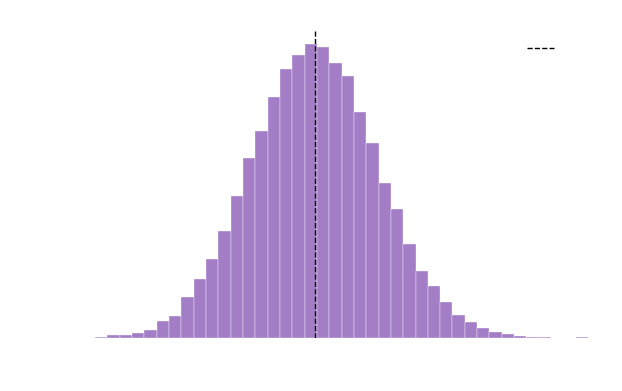

In [18]:
# Sentiment distribution (weighted neutral probability)
fig, ax = plt.subplots(figsize=(7, 4))
model_df['p_neutral_wmean'].hist(ax=ax, bins=40, color='#9467bd', edgecolor='white', alpha=0.85)
ax.set_xlabel('Weighted neutral sentiment')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of neutral sentiment')
ax.axvline(model_df['p_neutral_wmean'].mean(), color='black', linestyle='--', linewidth=1, label='Mean')
ax.legend()
save_figure(fig, 'sentiment_hist_neutral')


INFO: Saved figure to output/fig_dark/sentiment_trend_year.png


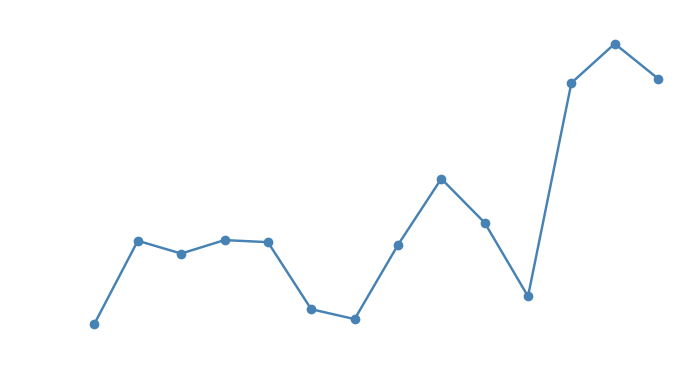

In [19]:
# Sentiment trends by year
sent_by_year = model_df.groupby(model_df['rdq'].dt.year)['p_positive_wmean'].mean().sort_index()
fig, ax = plt.subplots(figsize=(8, 4))
sent_by_year.plot(ax=ax, marker='o', color='steelblue')
ax.set_ylabel('Mean positive sentiment')
ax.set_xlabel('Year')
ax.set_title('Average positive sentiment by year')
ax.grid(alpha=0.3)
save_figure(fig, 'sentiment_trend_year')


INFO: Saved figure to output/fig_dark/sentiment_trend_all.png


,p_positive_wmean,p_negative_wmean,p_neutral_wmean
rdq,,,
2010,0.374237,0.167779,0.457983
2011,0.400587,0.157344,0.442068
2012,0.396530,0.173046,0.430424
2013,0.400802,0.166331,0.432868
2014,0.400151,0.148747,0.451102


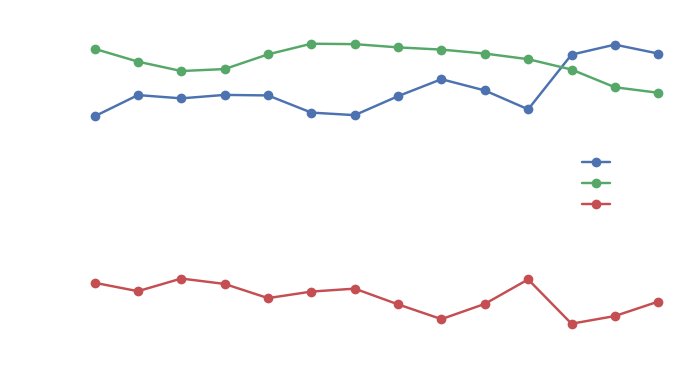

In [35]:
# Sentiment trends by year (positive vs negative)
sent_trend = model_df.groupby(model_df['rdq'].dt.year)[['p_positive_wmean', 'p_negative_wmean', 'p_neutral_wmean']].mean().sort_index()
fig, ax = plt.subplots(figsize=(8, 4))
sent_trend[['p_positive_wmean', 
            'p_neutral_wmean',
            'p_negative_wmean']].rename(columns={'p_positive_wmean': 'positive', 
                                                 'p_neutral_wmean': 'neutral', 
                                                 'p_negative_wmean': 'negative'}).plot(ax=ax, marker='o')
ax.set_ylabel('Mean sentiment probability')
ax.set_xlabel('Year')
ax.set_title('sentiments by year')
ax.grid(alpha=0.3)
save_figure(fig, 'sentiment_trend_all')
sent_trend.head()


INFO: Saved figure to output/fig_dark/sentiment_trend_pos_neg.png


p_positive_wmean  p_negative_wmean  p_neutral_wmean
rdq  rdq                                                     
2010 1            0.379671          0.172729         0.447600
     2            0.373441          0.172680         0.453879
     3            0.377630          0.167372         0.454997
     4            0.370614          0.161631         0.467755
2011 1            0.401705          0.149357         0.448938

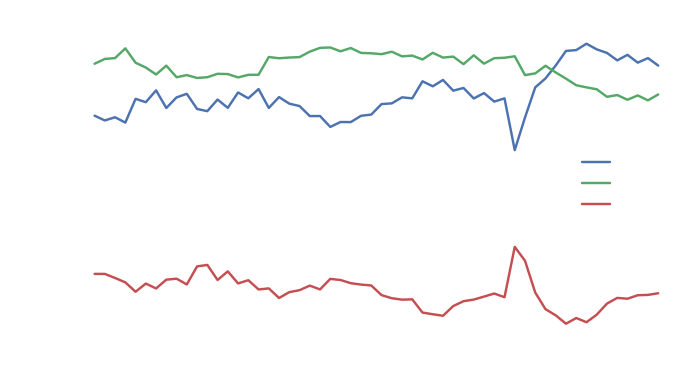

In [21]:
# Sentiment trends by year (positive vs negative)
sent_trend = model_df.groupby([model_df['rdq'].dt.year, model_df['rdq'].dt.quarter])[['p_positive_wmean', 'p_negative_wmean', 'p_neutral_wmean']].mean().sort_index()
fig, ax = plt.subplots(figsize=(8, 4))
sent_trend[['p_positive_wmean', 
            'p_neutral_wmean',
            'p_negative_wmean']].rename(columns={'p_positive_wmean': 'positive', 
                                                 'p_neutral_wmean': 'neutral', 
                                                 'p_negative_wmean': 'negative'}).plot(ax=ax)
ax.set_ylabel('Mean sentiment probability')
ax.set_xlabel('Year')
ax.set_title('Positive vs negative sentiment by year')
ax.grid(alpha=0.3)
save_figure(fig, 'sentiment_trend_pos_neg')
sent_trend.head()


INFO: Saved figure to output/fig_dark/sentiment_heatmap_year_quarter.png


rdq,1,2,3,4
rdq,,,,
2010,0.379671,0.373441,0.377630,0.370614
2011,0.401705,0.397287,0.412774,0.389725
2012,0.403592,0.408306,0.388479,0.385587
2013,0.400781,0.389901,0.410022,0.402436
2014,0.414454,0.389795,0.404029,0.395414


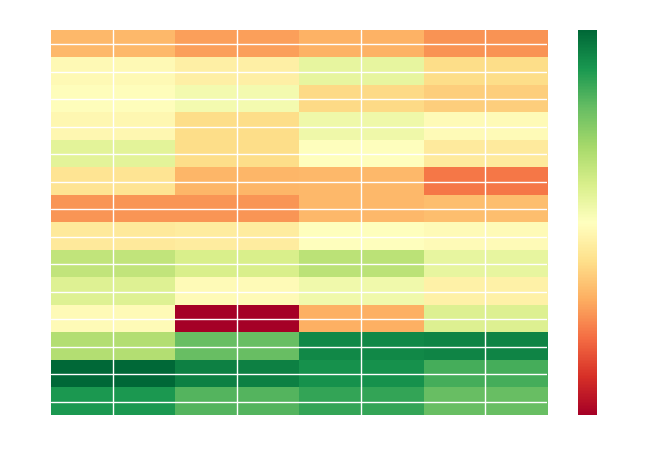

In [22]:
# Heatmap: mean sentiment by year and quarter
heatmap_df = model_df.groupby([model_df['rdq'].dt.year, model_df['rdq'].dt.quarter])['p_positive_wmean'].mean().unstack(1)
fig, ax = plt.subplots(figsize=(8, 5))
cax = ax.imshow(heatmap_df, aspect='auto', cmap='RdYlGn')
ax.set_xticks(range(len(heatmap_df.columns)))
ax.set_xticklabels([f'Q{q}' for q in heatmap_df.columns])
ax.set_yticks(range(len(heatmap_df.index)))
ax.set_yticklabels(heatmap_df.index)
ax.set_title('Mean positive sentiment by year/quarter')
fig.colorbar(cax, ax=ax, label='Mean sentiment')
save_figure(fig, 'sentiment_heatmap_year_quarter')
heatmap_df.head()


INFO: Saved figure to output/fig_dark/sentiment_share_stacked.png


,p_positive_wmean,p_negative_wmean,p_neutral_wmean
rdq,,,
2010,0.374237,0.167779,0.457983
2011,0.400587,0.157344,0.442068
2012,0.396530,0.173046,0.430424
2013,0.400802,0.166331,0.432868
2014,0.400151,0.148747,0.451102


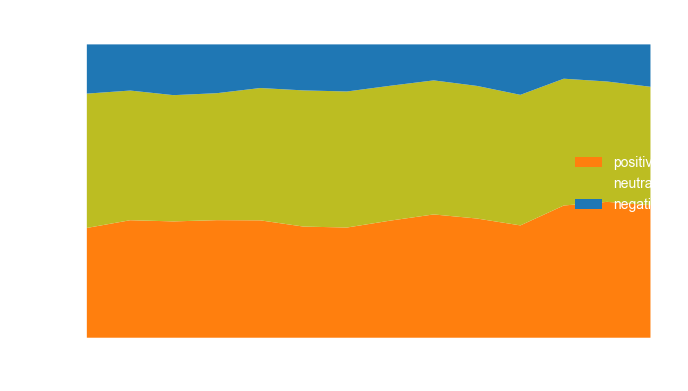

In [23]:
# Sentiment share per year (stacked area)
sent_share = model_df.groupby(model_df['rdq'].dt.year)[['p_positive_wmean', 'p_negative_wmean', 'p_neutral_wmean']].mean().sort_index()
fig, ax = plt.subplots(figsize=(8, 4))
ax.stackplot(sent_share.index, sent_share['p_positive_wmean'], sent_share['p_neutral_wmean'], sent_share['p_negative_wmean'], labels=['positive', 'neutral', 'negative'], colors=['#ff7f0e', '#bcbd22', '#1f77b4'])
ax.set_ylabel('Average probability share')
ax.set_xlabel('Year')
ax.set_title('Average sentiment mix by year')
ax.legend(loc='center right')
save_figure(fig, 'sentiment_share_stacked')
sent_share.head()


INFO: Saved figure to output/fig_dark/return_distributions.png


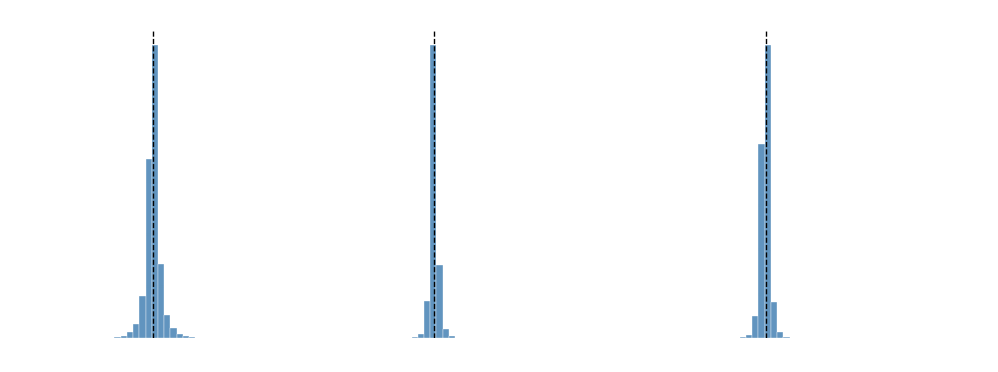

In [24]:
# Return distributions (1d, 3d, 5d)
fig, axes = plt.subplots(1, len(RETURN_WINDOWS), figsize=(12, 4))
for ax, window in zip(axes, RETURN_WINDOWS):
    col = f'return_{window}d'
    model_df[col].hist(ax=ax, bins=40, color='steelblue', edgecolor='white', alpha=0.85)
    ax.set_title(f'Return {window}d')
    ax.axvline(model_df[col].mean(), color='black', linestyle='--', linewidth=1)
    ax.grid(alpha=0.3)
save_figure(fig, 'return_distributions')


INFO: Saved figure to output/fig_dark/scatter_sentiment_return.png


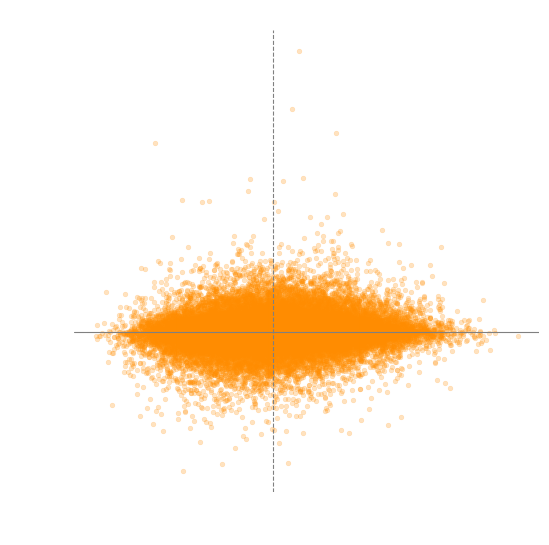

In [25]:
# Scatter: sentiment vs 1d return
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(model_df['p_positive_wmean'], model_df['return_1d'], alpha=0.25, s=12, color='darkorange')
ax.set_xlabel('Weighted positive sentiment')
ax.set_ylabel('Return 1d')
ax.axhline(0, color='grey', linewidth=0.8)
ax.axvline(model_df['p_positive_wmean'].mean(), color='grey', linewidth=0.8, linestyle='--')
ax.set_title('Sentiment vs next-day return')
corr = model_df[['p_positive_wmean', 'return_1d']].corr().iloc[0, 1]
ax.text(0.02, 0.95, f'Pearson r = {corr:.3f}', transform=ax.transAxes, fontsize=10)
save_figure(fig, 'scatter_sentiment_return')


INFO: Saved figure to output/fig_dark/scatter_negative_return.png


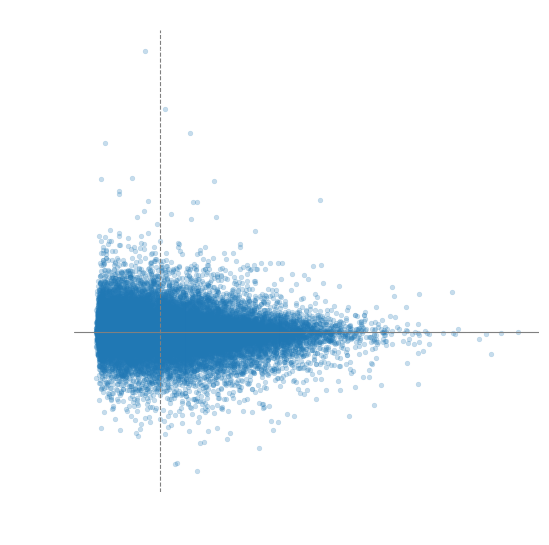

In [26]:
# Scatter: negative sentiment vs 1d return
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(model_df['p_negative_wmean'], model_df['return_1d'], alpha=0.25, s=12, color='#1f77b4')
ax.set_xlabel('Weighted negative sentiment')
ax.set_ylabel('Return 1d')
ax.axhline(0, color='grey', linewidth=0.8)
ax.axvline(model_df['p_negative_wmean'].mean(), color='grey', linewidth=0.8, linestyle='--')
ax.set_title('Negative sentiment vs next-day return')
corr_neg = model_df[['p_negative_wmean', 'return_1d']].corr().iloc[0, 1]
ax.text(0.02, 0.95, f'Pearson r = {corr_neg:.3f}', transform=ax.transAxes, fontsize=10)
save_figure(fig, 'scatter_negative_return')


INFO: Saved figure to output/fig_dark/scatter_neutral_return.png


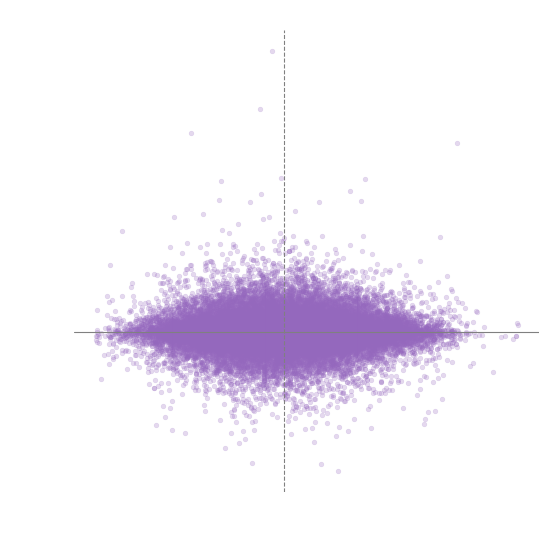

In [40]:
# Scatter: neutral sentiment vs 1d return
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(model_df['p_neutral_wmean'], model_df['return_1d'], alpha=0.25, s=12, color='#9467bd')
ax.set_xlabel('Weighted neutral sentiment')
ax.set_ylabel('Return 1d')
ax.axhline(0, color='grey', linewidth=0.8)
ax.axvline(model_df['p_neutral_wmean'].mean(), color='grey', linewidth=0.8, linestyle='--')
ax.set_title('Neutral sentiment vs next-day return')
corr_neut = model_df[['p_neutral_wmean', 'return_1d']].corr().iloc[0, 1]
ax.text(0.02, 0.95, f'Pearson r = {corr_neut:.3f}', transform=ax.transAxes, fontsize=10)
save_figure(fig, 'scatter_neutral_return')

INFO: Saved figure to output/fig_dark/decile_return_bar.png


,mean,median,count
sentiment_decile,,,
0,-0.006646,-0.002687,6280
1,-0.002222,-0.000605,6279
2,-0.001314,-0.000384,6279
3,0.002390,0.001332,6280
4,0.001041,0.000417,6279


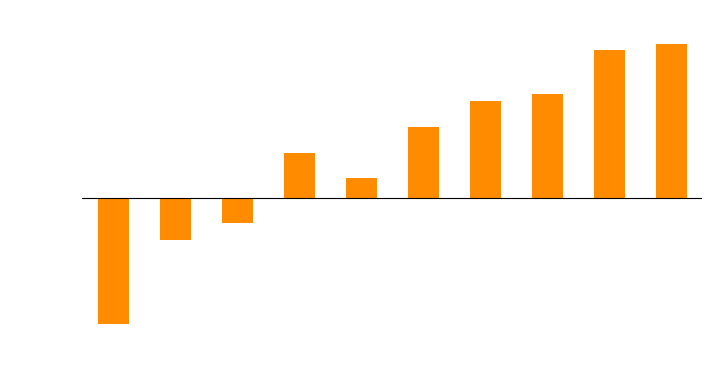

In [36]:
# Decile analysis: returns by sentiment decile
deciles = pd.qcut(model_df['p_positive_wmean'], 10, labels=False, duplicates='drop')
decile_table = model_df.groupby(deciles)['return_1d'].agg(['mean', 'median', 'count']).rename_axis('sentiment_decile')
fig, ax = plt.subplots(figsize=(8, 4))
decile_table['mean'].plot(kind='bar', ax=ax, color='darkorange')
ax.set_ylabel('Mean return 1d')
ax.set_title('Average 1d return by sentiment decile')
ax.axhline(0, color='black', linewidth=0.8)
ax.grid(axis='y', alpha=0.3)
save_figure(fig, 'decile_return_bar')
decile_table.head()


INFO: Saved figure to output/fig_dark/decile_return_bar_negative.png


,mean,median,count
negative_sentiment_decile,,,
0,0.010985,0.004910,6280
1,0.008095,0.003821,6279
2,0.005571,0.002635,6279
3,0.005052,0.002041,6280
4,0.003511,0.001304,6279


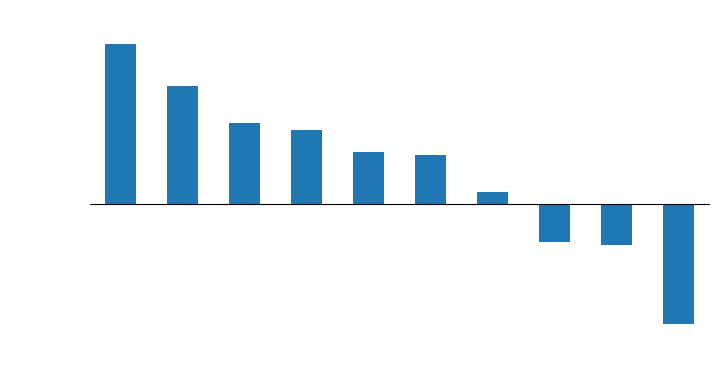

In [28]:
# Decile analysis: returns by negative sentiment decile
neg_deciles = pd.qcut(model_df['p_negative_wmean'], 10, labels=False, duplicates='drop')
neg_decile_table = model_df.groupby(neg_deciles)['return_1d'].agg(['mean', 'median', 'count']).rename_axis('negative_sentiment_decile')
fig, ax = plt.subplots(figsize=(8, 4))
neg_decile_table['mean'].plot(kind='bar', ax=ax, color='#1f77b4')
ax.set_ylabel('Mean return 1d')
ax.set_title('Average 1d return by negative sentiment decile')
ax.axhline(0, color='black', linewidth=0.8)
ax.grid(axis='y', alpha=0.3)
save_figure(fig, 'decile_return_bar_negative')
neg_decile_table.head()


INFO: Saved figure to output/fig_dark/decile_return_bar_neutral.png


,mean,median,count
neutral_sentiment_decile,,,
0,0.002570,0.000911,6280
1,0.001276,0.000241,6279
2,0.001721,0.000968,6279
3,0.002716,0.001473,6280
4,0.002433,0.000326,6279


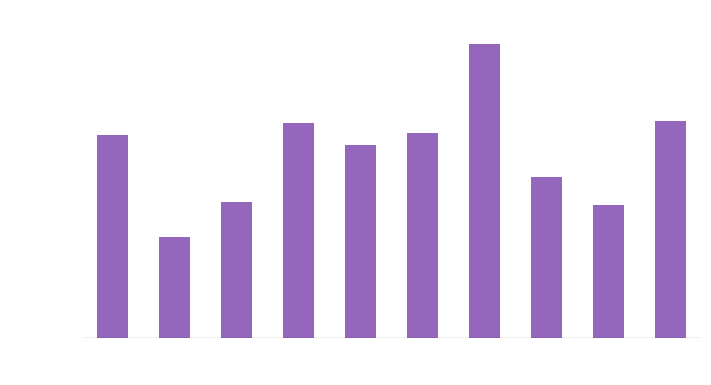

In [39]:
# Decile analysis: returns by neutral sentiment decile
neg_deciles = pd.qcut(model_df['p_neutral_wmean'], 10, labels=False, duplicates='drop')
neg_decile_table = model_df.groupby(neg_deciles)['return_1d'].agg(['mean', 'median', 'count']).rename_axis('neutral_sentiment_decile')
fig, ax = plt.subplots(figsize=(8, 4))
neg_decile_table['mean'].plot(kind='bar', ax=ax, color='#9467bd')
ax.set_ylabel('Mean return 1d')
ax.set_title('Average 1d return by neutral sentiment decile')
ax.axhline(0, color='black', linewidth=0.8)
ax.grid(axis='y', alpha=0.3)
save_figure(fig, 'decile_return_bar_neutral')
neg_decile_table.head()


In [29]:
# Market context: SPY vs counts of extreme sentiment
spy_prices = price_df[price_df['Ticker'] == 'SPY'].copy()
spy_prices = spy_prices.sort_values('Date')
if not spy_prices.empty:
    counts_extreme = model_df.assign(
        sentiment_bucket=np.select(
            [model_df['p_positive_wmean'] >= 0.6, model_df['p_negative_wmean'] >= 0.6],
            ['high_positive', 'high_negative'],
            default='neutral'
        )
    ).groupby([model_df['rdq'].dt.to_period('Q'), 'sentiment_bucket']).size().unstack(fill_value=0)
    counts_extreme.index = counts_extreme.index.to_timestamp()
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [3, 2]})
    ax1.plot(spy_prices['Date'], spy_prices['CloseAdjusted'], color='steelblue')
    ax1.set_ylabel('SPY Close')
    ax1.set_title('Market context and sentiment extremes')
    counts_extreme[['high_positive', 'high_negative']].plot(kind='bar', ax=ax2, stacked=True, color=['#2ca02c', '#d62728'])
    ax2.set_ylabel('Count')
    ax2.legend(loc='upper right')
    save_figure(fig, 'market_context_extremes')
else:
    logging.warning('SPY not found in price data; skipping market context plot.')


## Regression: Do sentiment features explain post-call returns?


In [46]:
sentiment_cols = sentiment_feature_columns(model_df)
return_cols = [f'return_{w}d' for w in RETURN_WINDOWS]
logging.info('Using sentiment features: %s', sentiment_cols)
baseline_df = model_df.dropna(subset=sentiment_cols + ['return_1d']).copy()
X = baseline_df[sentiment_cols]
y = baseline_df['return_1d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
metrics = {
    'n_obs': int(len(baseline_df)),
    'n_train': int(len(X_train)),
    'n_test': int(len(X_test)),
    'r2_train': r2_score(y_train, y_pred_train),
    'r2_test': r2_score(y_test, y_pred_test),
    'rmse_train': rmse_train,
    'rmse_test': rmse_test,
}
metrics


INFO: Using sentiment features: ['p_positive_wmean', 'p_negative_wmean', 'p_neutral_wmean', 'entropy_wmean', 'max_positive', 'max_negative']


{'n_obs': 62794,
 'n_train': 47095,
 'n_test': 15699,
 'r2_train': 0.009903297956483703,
 'r2_test': 0.0075997557152613915,
 'rmse_train': np.float64(0.061738490200777686),
 'rmse_test': np.float64(0.061749460104257345)}

INFO: Saved figure to output/fig_dark/regression_coefficients.png


,feature,coefficient
1,p_negative_wmean,-23268.039179
2,p_neutral_wmean,-23268.004015
0,p_positive_wmean,-23267.990292
3,entropy_wmean,-0.024779
4,max_positive,0.012478


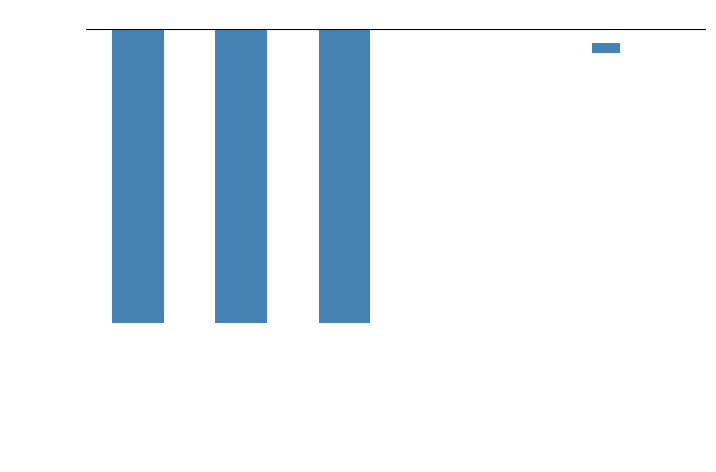

In [47]:
coef_df = pd.DataFrame({
    'feature': sentiment_cols,
    'coefficient': model.coef_,
}).sort_values(by='coefficient', key=lambda s: s.abs(), ascending=False)
fig, ax = plt.subplots(figsize=(8, 4))
coef_df.plot(kind='bar', x='feature', y='coefficient', ax=ax, color='steelblue')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel('Coefficient')
ax.set_title('Linear regression coefficients (return 1d)')
ax.tick_params(axis='x', rotation=45)
# ax.tick_params(axis='x', rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
save_figure(fig, 'regression_coefficients')
coef_df.head()


INFO: Saved figure to output/fig_dark/residual_histogram.png
INFO: Saved figure to output/fig_dark/residuals_vs_fitted.png


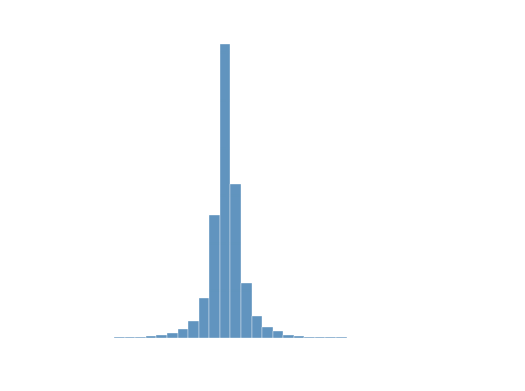

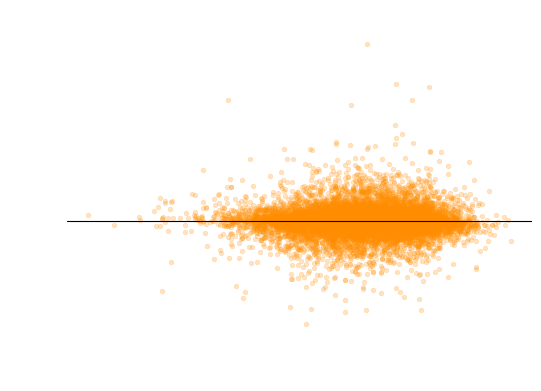

In [48]:
# Residual diagnostics
residuals = y_test - model.predict(X_test)
fig, ax = plt.subplots(figsize=(6, 4))
residuals.hist(ax=ax, bins=40, color='steelblue', edgecolor='white', alpha=0.85)
ax.set_title('Test residuals distribution')
ax.set_xlabel('Residual')
ax.grid(alpha=0.3)
save_figure(fig, 'residual_histogram')
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(model.predict(X_test), residuals, alpha=0.25, s=12, color='darkorange')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs fitted')
ax.grid(alpha=0.3)
save_figure(fig, 'residuals_vs_fitted')


In [33]:
# Export artefacts for presentation/reporting
metrics_path = OUTPUT_DIR / 'regression_metrics.json'
with metrics_path.open('w') as f:
    json.dump(metrics, f, indent=2)
logging.info('Saved regression metrics to %s', metrics_path)
coef_path = OUTPUT_DIR / 'regression_coefficients.csv'
coef_df.to_csv(coef_path, index=False)
logging.info('Saved coefficients to %s', coef_path)


INFO: Saved regression metrics to output/regression_metrics.json
INFO: Saved coefficients to output/regression_coefficients.csv
